## Data analysis code for gain=5000 data taken on 06/12/2025. Code copied from 06/06/2025

In [23]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py
from scipy.fft import fft, fftfreq

In [224]:
import numpy as np
import matplotlib.pyplot as plt

def fit_signal_with_fft(times, values, num_freqs=3, poly_deg=2, plot=True):
    """
    Fit a time-domain signal using FFT and polynomial baseline over a selected window,
    then extrapolate the model to the entire time span.

    Parameters:
    - times (np.ndarray): Full time array.
    - values (np.ndarray): Full signal array.
    - num_freqs (int): Number of FFT components to use.
    - poly_deg (int): Degree of polynomial baseline.
    - plot (bool): Whether to plot the full fit and residuals.

    Returns:
    - fit_full (np.ndarray): Extrapolated fit over the entire signal.
    - top_freqs (list): Top detected frequencies [Hz].
    - poly_coeffs (np.ndarray): Polynomial coefficients.
    """

    # === Select fitting region ===
    fit_start = 1199   # change this index as needed, 
    fit_end = -1       # or a positive index

    times_fit = times[fit_start:fit_end]
    values_fit = values[fit_start:fit_end]

    # Time shift for fitting
    times_fit_shifted = times_fit - times_fit[0]

    # === Step 1: Polynomial baseline over fit region ===
    poly_coeffs = np.polyfit(times_fit_shifted, values_fit, deg=poly_deg)
    baseline_fit = np.polyval(poly_coeffs, times_fit_shifted)
    values_detrended = values_fit - baseline_fit

    # === Step 2: FFT ===
    dt = times_fit_shifted[1] - times_fit_shifted[0]
    N = len(times_fit_shifted)
    yf = np.fft.rfft(values_detrended)
    xf = np.fft.rfftfreq(N, d=dt)

    # === Step 3: Top frequencies ===
    magnitudes = np.abs(yf)
    magnitudes[0] = 0  # ignore DC
    peak_indices = magnitudes.argsort()[-num_freqs:][::-1]
    top_freqs = xf[peak_indices].tolist()

    # === Step 4: Reconstruct over full time ===
    times_shifted_full = times - times_fit[0]  # shift full time array to match fit origin
    fit_fft_full = np.zeros_like(times_shifted_full)
    for i in peak_indices:
        freq = xf[i]
        comp = yf[i]
        fit_fft_full += 2 * np.real(comp * np.exp(1j * 2 * np.pi * freq * times_shifted_full)) / N

    baseline_full = np.polyval(poly_coeffs, times_shifted_full)
    fit_full = fit_fft_full + baseline_full

    # === Plotting ===
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(times, values, label='Original Signal', alpha=0.6)
        plt.plot(times, fit_full, '--', label='Extrapolated Fit', linewidth=2)
        plt.axvspan(times[fit_start], times[fit_end], color='orange', alpha=0.1, label='Fit Window')
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.title(f"Full Signal Fit: {num_freqs} FFT Components + Poly(deg={poly_deg})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Residuals
        residuals = values - fit_full
        plt.figure(figsize=(10, 2.5))
        plt.plot(times, residuals, color='gray', label='Residual')
        plt.axhline(0, linestyle='--', color='red')
        plt.xlabel("Time [s]")
        plt.ylabel("Residual")
        plt.title("Residual: Original - Extrapolated Fit")
        plt.tight_layout()
        plt.show()
        print('Total Residual', np.sum(np.abs(residuals[0:fit_start])))

        print(f"Top {num_freqs} detected frequencies [Hz]:")
        for i, f in enumerate(top_freqs):
            print(f"  {i+1}: {f:.2f} Hz")

    return fit_full, top_freqs, poly_coeffs


# Binning 1x1

In [257]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence_Raster\2025\06\13'
seq = 2 #sequence number

2025-06-13_0002_BaF_Fluorescence_Raster_27.h5
(6000,)


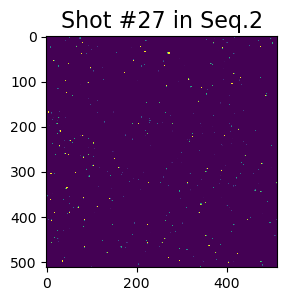

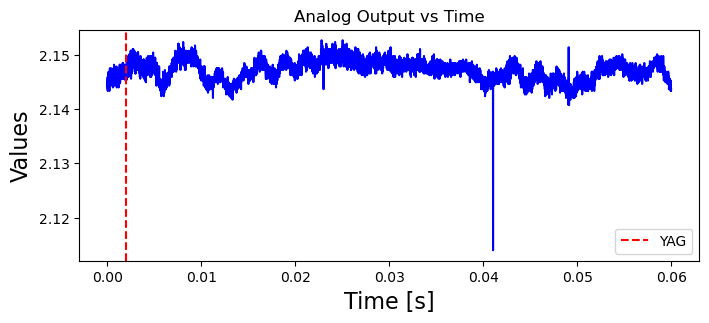

In [268]:
##Show Absorption and FLuorescence plots of a single shot
shot_number =27 #Choose shot number you want to see

folder_path = folder_path_day + '\\%.4i'%seq
for count_b, filename in enumerate(os.listdir(folder_path)):
      if count_b==shot_number: 
          file_path = os.path.join(folder_path, filename)
          print(filename)
          with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            analog_data=file['data/traces/Absorption'][:]
            # print(analog_data)
            times, values = zip(*analog_data)
            # Convert to NumPy arrays if needed
            times = np.array(times)
            values = np.array(values)
            print(np.shape(values))
            tYAG=2e-3 # Hardcoded for now...
            fig = plt.figure(2, figsize=(3, 3))
            plt.imshow(image_data, vmin = 1550, vmax = 1600)
            plt.title('Shot #%i in Seq.%i' % (shot_number, seq), fontsize=16)
            
            fig = plt.figure(4, figsize=(8, 3))
            plt.plot(times, values, 'b')
            plt.axvline(x=tYAG, color='r', linestyle='--', label='YAG')
            plt.xlabel('Time [s]', fontsize=16)
            plt.ylabel('Values', fontsize=16)
            plt.title('Analog Output vs Time')
            plt.legend()  # Add this if you want the 'YAG' label to show
            plt.show()

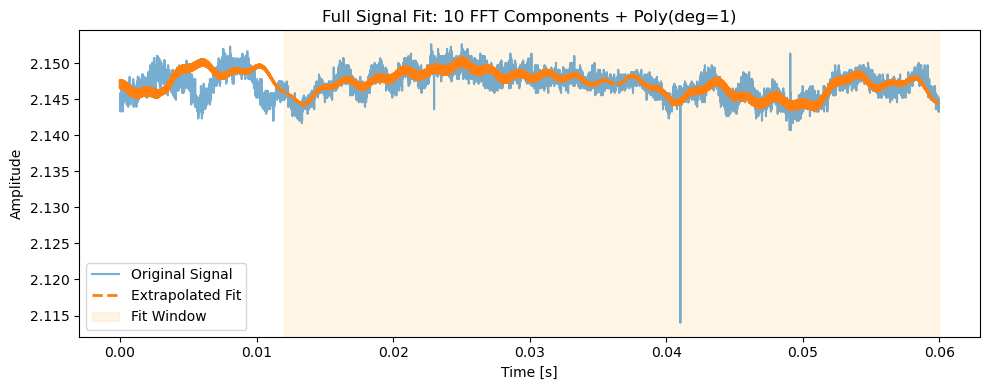

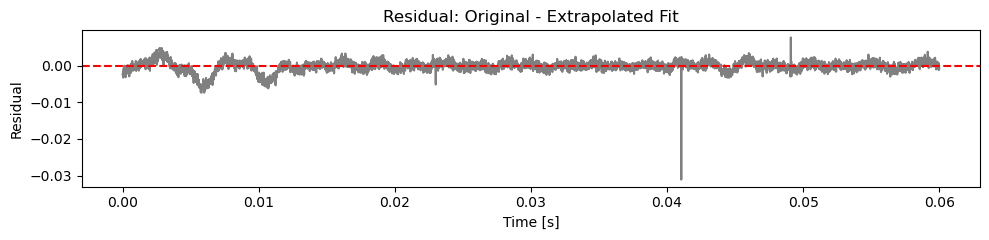

Total Residual 2.253837176649073
Top 10 detected frequencies [Hz]:
  1: 20.83 Hz
  2: 62.50 Hz
  3: 41.67 Hz
  4: 83.33 Hz
  5: 187.50 Hz
  6: 49979.17 Hz
  7: 104.17 Hz
  8: 208.33 Hz
  9: 145.83 Hz
  10: 479.17 Hz


In [269]:
# Example (remove when using real data):
# times = np.linspace(0, 2.5, 2500)
# values = np.sin(2*np.pi*30*times) + 0.7*np.sin(2*np.pi*90*times + 0.3) + 0.3*np.sin(2*np.pi*200*times + 1)

# fit, freqs = fit_signal_with_fft(times, values, num_freqs=10)
fit, freqs, poly = fit_signal_with_fft(times, values, num_freqs=10,poly_deg=1)



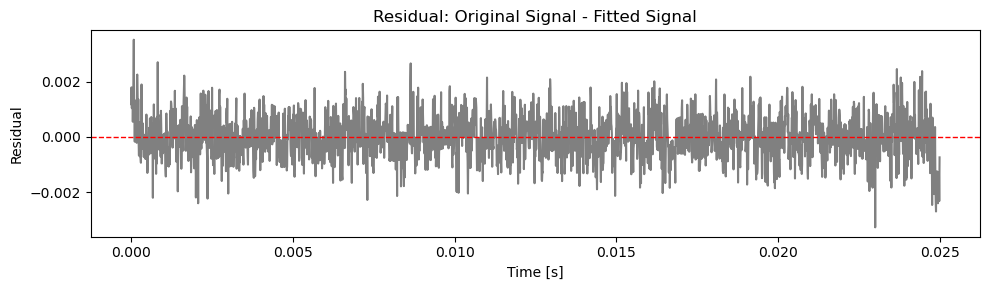

1.5420203718747647


In [100]:
# Assume you've already run:
# fit, freqs, poly = fit_signal_with_fft(times, values, num_freqs=3, poly_deg=2, plot=True)

# Now plot the residual separately
residual = values - fit

plt.figure(figsize=(10, 3))
plt.plot(times, residual, color='gray')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Time [s]")
plt.ylabel("Residual")
plt.title("Residual: Original Signal - Fitted Signal")
plt.tight_layout()
plt.show()
print(np.sum(np.abs(residual)))


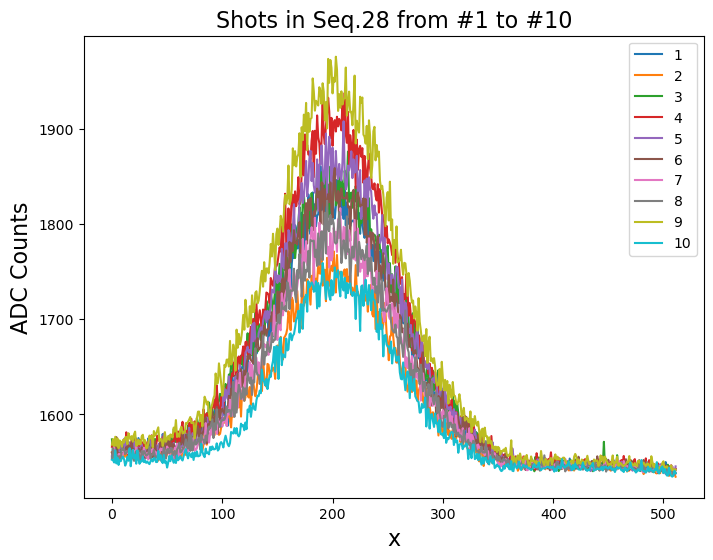

In [271]:
count_b_start=1
count_b_end=10
sum_array=[]
fig = plt.figure(20, figsize=(8,6))
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    if count_b<=count_b_end and count_b>=count_b_start:
    # if np.any(np.array([4,6,8,9,12,14,15, 17, 18])==count_b):
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            cross_section_x = np.mean(image_data, axis=0)
            # if np.any(cross_section_x>1550):
            plt.plot(np.arange(512),cross_section_x, label=count_b)
            # print(count_b)
            # print(np.sum(cross_section_x))
            sum_array.append(np.sum(cross_section_x))
            # else:
                # plt.plot(np.arange(512),cross_section_x, label='')


# plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('ADC Counts', fontsize=16)
plt.legend()
plt.show()



1
2
5
6
7
8


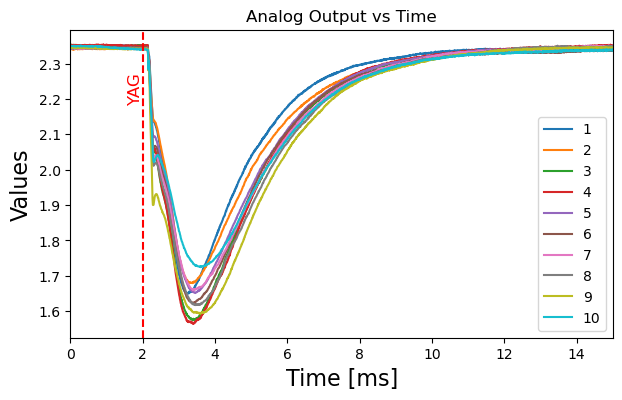

In [273]:
# ABSORPTION
plt.close()
count_b_start=1
count_b_end=10
sum_array=[]

fig = plt.figure(20, figsize=(7,4))
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    if count_b<=count_b_end and count_b>=count_b_start: #POINT WE STOPPED TAKING DATA...
        # if count_b%10==2:
        # print(count_b)
        with h5py.File(file_path, 'r') as file:
            analog_data=file['data/traces/BaF X-B Absorption'][:]
            # print(analog_data)
            times, values = zip(*analog_data)
            # Convert to NumPy arrays if needed
            times = np.array(times)*1000
            values = np.array(values)
            if np.any(values<1.7):
                if not np.any(values<1.6):
                    print(count_b)
            plt.plot(times, values, label=count_b)


tYAG=2 # [ms], Hardcoded for now...
plt.text(tYAG, plt.ylim()[1]*0.95, 'YAG', color='r', fontsize=12, rotation=90,
         verticalalignment='top', horizontalalignment='right')
plt.axvline(x=tYAG, color='r', linestyle='--')
plt.xlabel('Time [ms]', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.xlim([0,15])
plt.title('Analog Output vs Time')
plt.legend()  # Add this if you want the 'YAG' label to show
plt.show()



Let's  choose 3 plots at roughly the same absorption and average, then plot Sequences 31, 32, and 33 on the same plot.

From Sequence 31: Shots 10, 12, 13

From Sequence 32: Shots 1, 3, 9

From Sequence 33: Shots 7, 13, 19

[10]
[1]
[5]


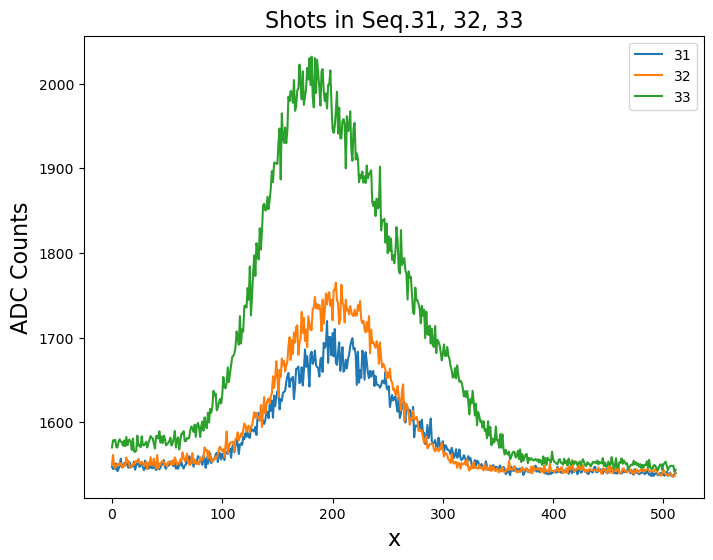

In [216]:
plt.close()
seq_array=np.array([31,32,33])
shot_array = np.array([
    [10, 12, 13],
    [1,  3,  9],
    [7, 13, 19]
])


fig = plt.figure(20, figsize=(8,6))

count=0
for seq in seq_array:
    folder_path = folder_path_day + '\\%.4i'%seq
    # get x-cross section for every shot in the sequence
    print(shot_array[count,:])
    cross_section_x_array=[]
    for count_b, filename in enumerate(os.listdir(folder_path)): 
        file_path = os.path.join(folder_path, filename)
        # print(filename)
        if np.any(count_b==shot_array[count,:]): #POINT WE STOPPED TAKING DATA...
            with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                cross_section_x = np.mean(image_data, axis=0)
                cross_section_x_array.append(cross_section_x)
    count+=1
    cross_section_x_average=np.mean(cross_section_x_array, axis=0)
    plt.plot(np.arange(512),cross_section_x_average, label=seq)


# plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
plt.title('Shots in Seq.31, 32, 33', fontsize=16)
plt.ylabel('ADC Counts', fontsize=16)
plt.legend()
plt.show()



In [201]:
shot_array = np.array([
    [10, 12, 13],
    [1,  3,  9],
    [7, 13, 19]
])

count = 0
print(shot_array[count, :])

[10 12 13]


# Photon counting LIF with threshold count=1576

In [325]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence_Raster\2025\06\06'
seq = 27 #sequence number
folder_path = folder_path_day + '\\%.4i'%seq

2025-06-06_0027_BaF_Fluorescence_Raster_00.h5
2025-06-06_0027_BaF_Fluorescence_Raster_01.h5
2025-06-06_0027_BaF_Fluorescence_Raster_02.h5
2025-06-06_0027_BaF_Fluorescence_Raster_03.h5
2025-06-06_0027_BaF_Fluorescence_Raster_04.h5
2025-06-06_0027_BaF_Fluorescence_Raster_05.h5
2025-06-06_0027_BaF_Fluorescence_Raster_06.h5
2025-06-06_0027_BaF_Fluorescence_Raster_07.h5
2025-06-06_0027_BaF_Fluorescence_Raster_08.h5
2025-06-06_0027_BaF_Fluorescence_Raster_09.h5
2025-06-06_0027_BaF_Fluorescence_Raster_10.h5
2025-06-06_0027_BaF_Fluorescence_Raster_11.h5
2025-06-06_0027_BaF_Fluorescence_Raster_12.h5
2025-06-06_0027_BaF_Fluorescence_Raster_13.h5
2025-06-06_0027_BaF_Fluorescence_Raster_14.h5
2025-06-06_0027_BaF_Fluorescence_Raster_15.h5
2025-06-06_0027_BaF_Fluorescence_Raster_16.h5
2025-06-06_0027_BaF_Fluorescence_Raster_17.h5
2025-06-06_0027_BaF_Fluorescence_Raster_18.h5
2025-06-06_0027_BaF_Fluorescence_Raster_19.h5


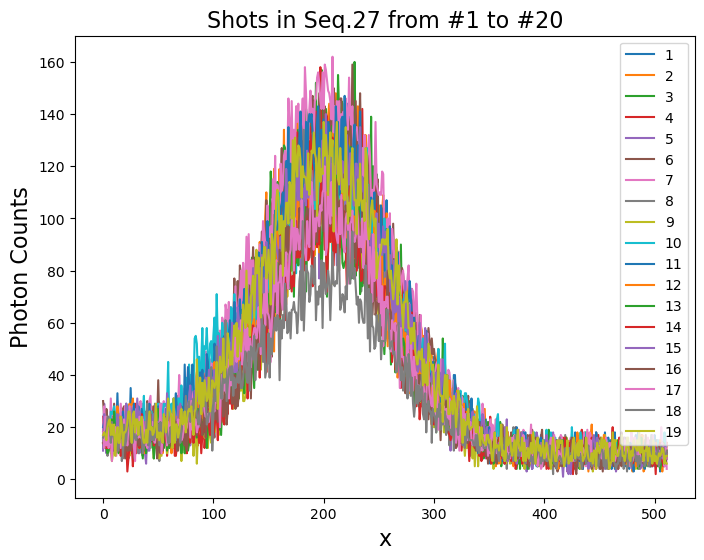

In [329]:
count_b_start=1
count_b_end=20
sum_array=[] #total photons
fig = plt.figure(20, figsize=(8,6))
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    print(filename)
    if count_b<=count_b_end and count_b>=count_b_start:
    # if np.any(np.array([4,6,8,9,12,14,15, 17, 18])==count_b):
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<1576]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            # if np.any(cross_section_x>1550):
            plt.plot(np.arange(512),cross_section_x, label=count_b)
            # print(count_b)
            # print(np.sum(cross_section_x))
            sum_array.append(np.sum(cross_section_x))
            # else:
                # plt.plot(np.arange(512),cross_section_x, label='')


# plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()



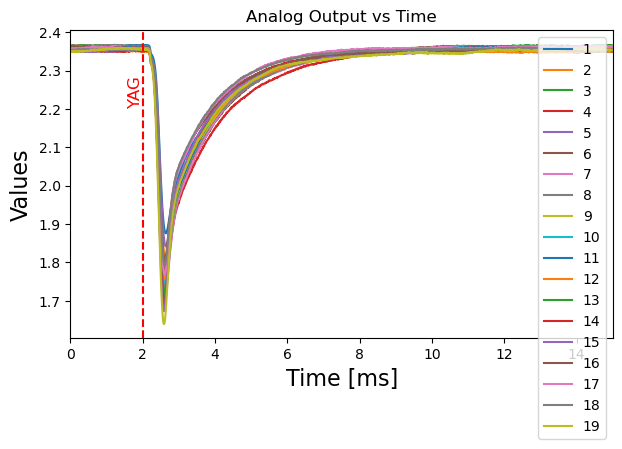

In [330]:
# ABSORPTION
plt.close()
count_b_start=1
count_b_end=20
sum_array2=[]
integral_threshold=2.3

fig = plt.figure(20, figsize=(7,4))
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    if count_b<=count_b_end and count_b>=count_b_start: #POINT WE STOPPED TAKING DATA...
        # if count_b%10==2:
        # print(count_b)
        with h5py.File(file_path, 'r') as file:
            analog_data=file['data/traces/BaF X-B Absorption'][:]
            # print(analog_data)
            times, values = zip(*analog_data)
            # Convert to NumPy arrays if needed
            times = np.array(times)*1000
            values = np.array(values)
            plt.plot(times, values, label=count_b)
            integrated_absorption=np.sum(values < integral_threshold)*integral_threshold - np.sum(values[values<integral_threshold]) 
            sum_array2.append(integrated_absorption)


tYAG=2 # [ms], Hardcoded for now...
plt.text(tYAG, plt.ylim()[1]*0.95, 'YAG', color='r', fontsize=12, rotation=90,
         verticalalignment='top', horizontalalignment='right')
plt.axvline(x=tYAG, color='r', linestyle='--')
plt.xlabel('Time [ms]', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.xlim([0,15])
plt.title('Analog Output vs Time')
plt.legend()  # Add this if you want the 'YAG' label to show
plt.show()



<Figure size 640x480 with 0 Axes>

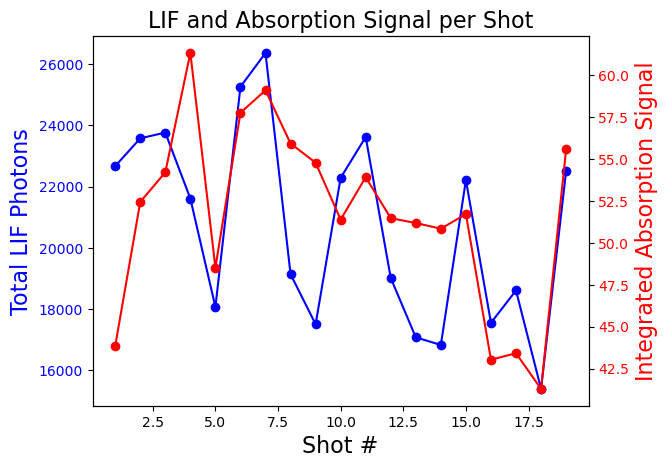

In [331]:
plt.figure()
fig, ax1 = plt.subplots()  # Create the main axis

# Left y-axis
ax1.plot(np.arange(1, 20), sum_array, 'bo-', label="LIF Photons")
ax1.set_xlabel("Shot #", fontsize=16)
ax1.set_ylabel("Total LIF Photons", fontsize=16, color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Right y-axis
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
ax2.plot(np.arange(1, 20), sum_array2, 'ro-', label="Absorption Signal")
ax2.set_ylabel("Integrated Absorption Signal", fontsize=16, color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("LIF and Absorption Signal per Shot", fontsize=16)
plt.show()